這邊利用課本中的範例4.1來說明策略迭代的過程，程式碼主要參考的是[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter04/grid_world.py)，再加上自己理解的註解。

載入需求套件

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

%matplotlib inline 
# matplotlib.use('Agg') # 主要是限制不讓圖片列印在畫面上，看需求自己調整

定義環境

首先，課本中的grid size=4

In [3]:
WORLD_SIZE = 4

定義action space，且每一個action的機率是相等的

In [4]:
# 下、左、上、右
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTION_PROB = 0.25

設置相關需求函數

課本中提到，左上(0,0)與右下的灰色格子就是終止狀態(terminal state)

In [5]:
def is_terminal(state):
    """判斷是否為終止狀態"""
    x, y = state
    return (x == 0 and y == 0) or (x == WORLD_SIZE - 1 and y == WORLD_SIZE - 1)

每個step-action pair之後會得到的reward與next state

In [6]:
def step(state, action):
    """每個state action pair之後的s'、r
    
    state: current state
    action: 選定的action
    
    1。首先我們會先判斷是否為終止狀態，如果當前位置已經是在終止狀態的地方，那就會結束這個episode
    2，取得下一個狀態之後我們要先判斷是否超過邊界，如果超出邊界那就停在原地不動
    3，在到達終止狀態之前，每一個action都會得到reward r=-1
    
    return:
        next state, reward
    """
    if is_terminal(state):
        return state, 0

    next_state = (np.array(state) + action).tolist()
    x, y = next_state

    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        next_state = state

    reward = -1
    return next_state, reward

這邊給出公式4.5：
$$
\begin{align}
v_{k+1}(s) &\dot{=} \mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1}) \vert S_{t}=s] \\
&=\sum_a \pi(a \vert s) \sum_{s',r} p(s', r\vert s, a)[r + \gamma v_k(s')] \tag{4.5}
\end{align}
$$

In [8]:
def compute_state_value(in_place=True, discount=1.0):
    """policy evaluation function
    
    in_place: 根據課本，這有兩種作法，兩個array或是一個array做in-place的處理
    discount: discount factor，根據課本的說明，這個範例是沒有discount的
    
    這邊主要計算的是迭代過程中每個state的估測值，
    因此我們會需要一個matrix來記錄每一個state的value，因此設置new_state_values來記錄，
    
    迭代過程中，我們會計算每一個state的每一個action會得到的value，
    並套用公式4.5來計算每一個state所估測出來的價值(value)
    
    基本上課本上有特別提到，每一個action都是等機率的，因此這代表每一個action都有25%被選中，
    雖然程式碼中沒有計算給定s, a的情況下得到s', r的機率，
    不過廣義來看這也是GPI的一種形式。
    
    每一次迭代的結束，我們都會計算新的value與舊的value之間的差異，
    如果變動的幅度小於我們所設置的閥止，那就停止迭代，
    也就代表我們已經得到那個state value function，
    大概就是，給定一個state，你就可以利用new_state_values的記錄來說明這個state所估測的value是多少
    
    當然你也可以把閥值的部份拉出來做為參數來設定
    
    return:
        new_state_values: 每一個state的新的估測值
        iteration: 目前執行的迭代次數
    """
    new_state_values = np.zeros((WORLD_SIZE, WORLD_SIZE))
    iteration = 0
    while True:
        if in_place:
            state_values = new_state_values
        else:
            state_values = new_state_values.copy()
            
        old_state_values = state_values.copy()

        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                value = 0
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    value += ACTION_PROB * (reward + discount * state_values[next_i, next_j])
                new_state_values[i, j] = value

        max_delta_value = abs(old_state_values - new_state_values).max()
        if max_delta_value < 1e-4:
            break

        iteration += 1

    return new_state_values, iteration

上面這樣已經可以執行了，測試看看

In [12]:
values_asycn, asycn_iteration = compute_state_value(in_place=True)
values_sync, sync_iteration = compute_state_value(in_place=False)

現在我們來看看兩種不同方式的收斂結果為何

In [13]:
asycn_iteration, sync_iteration

(113, 172)

上面結果可以看的到，in-place的update方式確實在收斂效率上快了不少

接下來ShangtongZhang也很貼心的幫我們弄好圖表的建置，一樣的來研究看看

下面先給出`np.ndenumerate`的官方文件範例

In [20]:
a = np.array([[1, 2], [3, 4]])
for index, x in np.ndenumerate(a):
    print(index, x)

(0, 0) 1
(0, 1) 2
(1, 0) 3
(1, 1) 4


In [48]:
def draw_image(image):
    """繪製圖表
    
    image: policy evaluation之後得到的value matrix
    """
    # 設置子圖
    fig, ax = plt.subplots()
    # 關閉軸距
    ax.set_axis_off()
    # 建置一個table
    tb = Table(ax)
    # 定義rows, columns的數量
    nrows, ncols = image.shape
    # 定義大小
    width, height = 1.0 * 5 / ncols, 1.0 * 5 / nrows

    # 依據index加入cell
    for (i, j), val in np.ndenumerate(image):
        tb.add_cell(i, j, width, height, text=np.round(val),
                    loc='center', facecolor='white')

    # 加入rows、cols的說明
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')
    # 設置字型大小
    tb.set_fontsize(28)
    # table加入圖表
    ax.add_table(tb)
    plt.show()

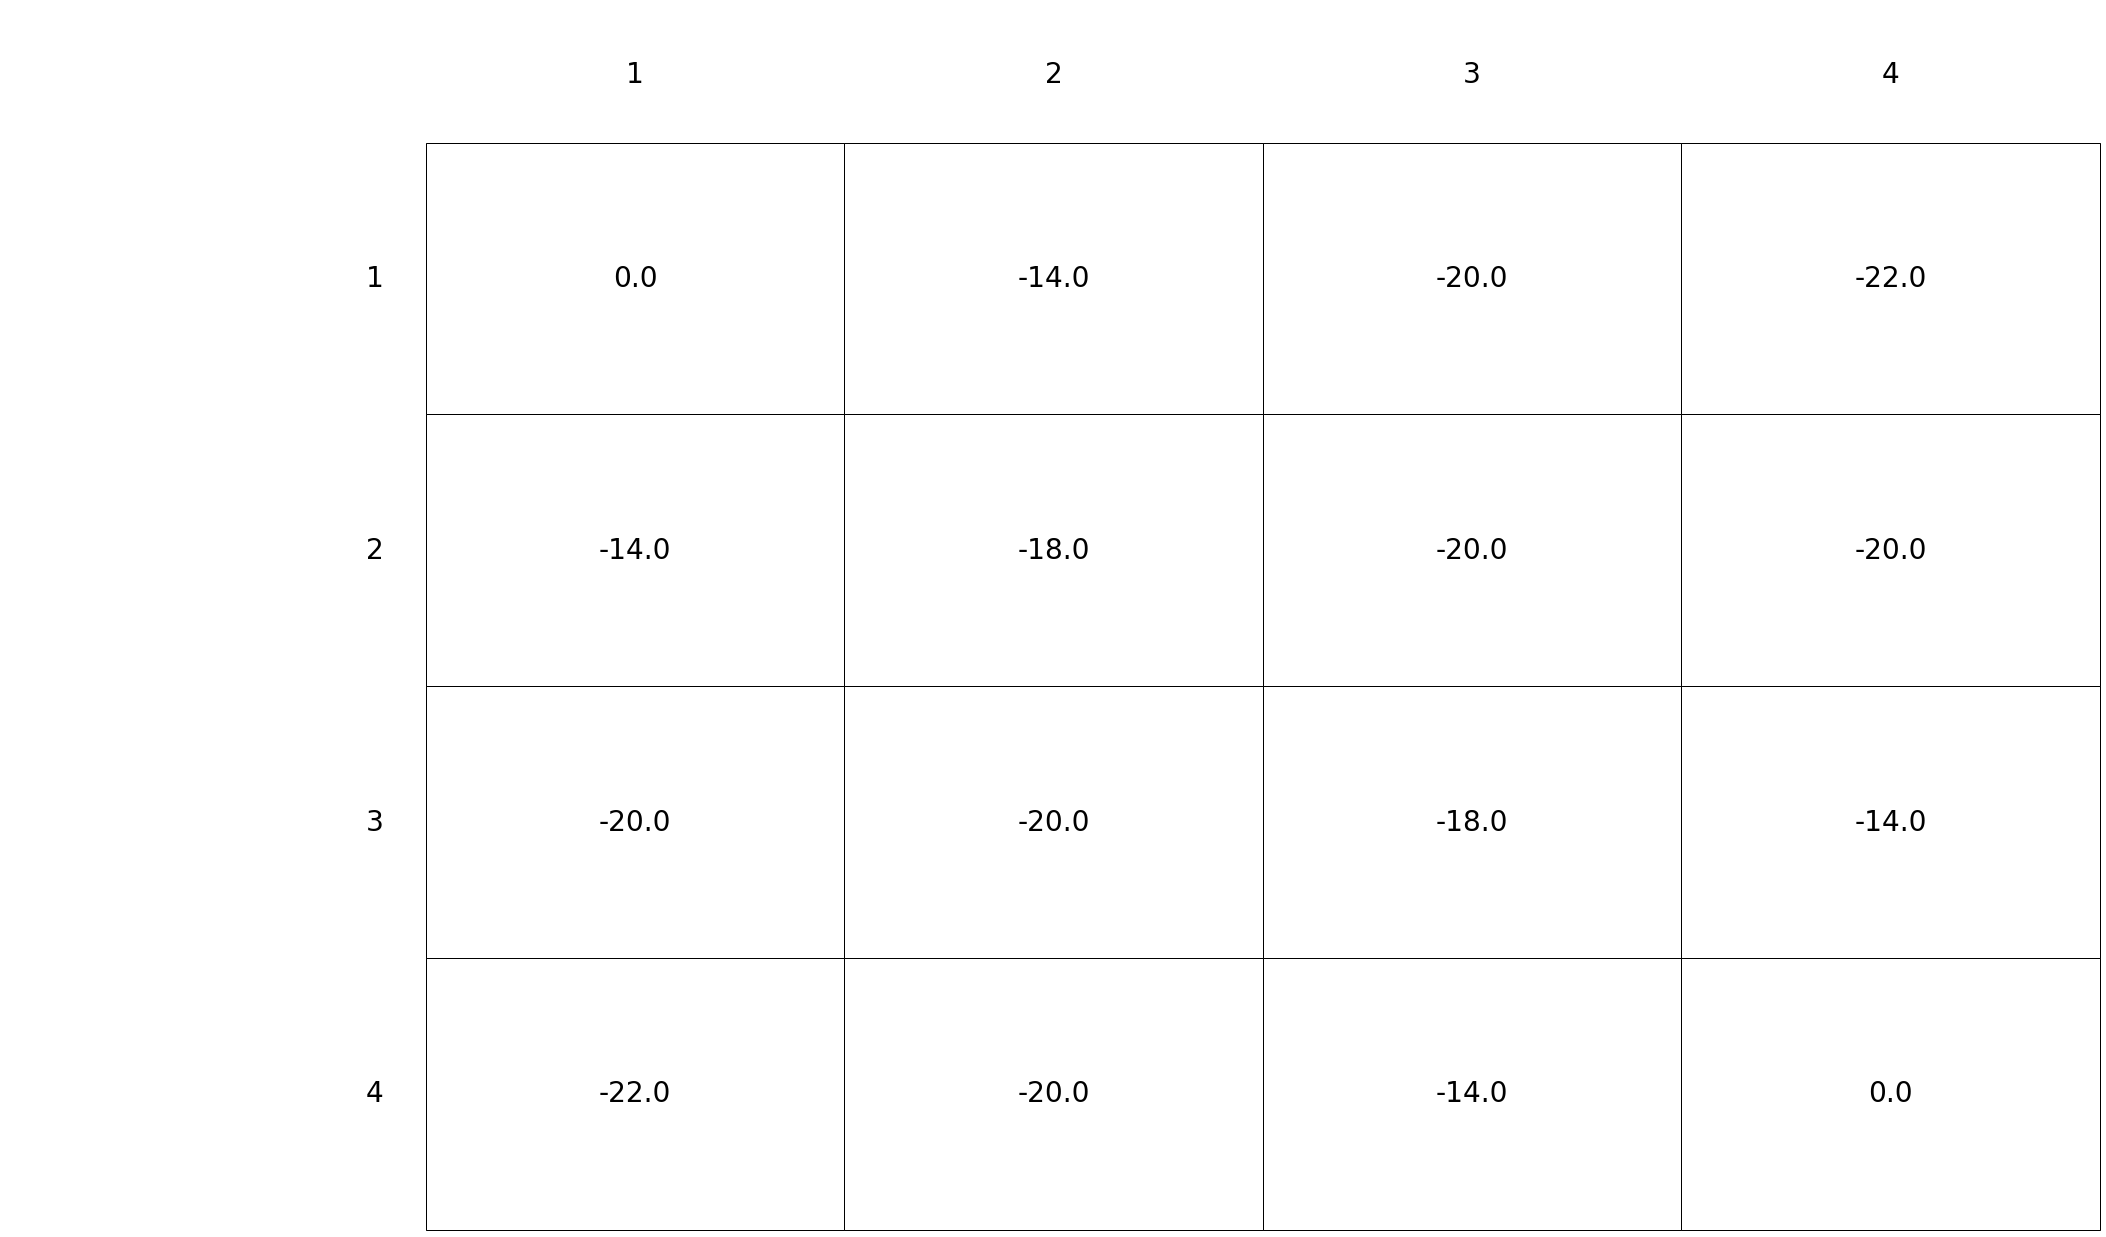

In [49]:
draw_image(values_asycn)

回頭比對課本應該不難發現，四捨五入之後的結果是一致的